# North Atlantic Basin (CM2.6)

In [37]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
#options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster()
cluster.scale(15)
client = cluster.get_client()

2024-08-14 15:04:58,208 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [10]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [11]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.670754b04b3a4bdabbb6cc6390b5b35c/status,


In [45]:
cluster.close()
client.close()

In [15]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import gcsfs
import gcm_filters
import xgcm
from xhistogram.xarray import histogram
import cmocean

In [7]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/srv/conda/envs/notebook/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes

In [18]:
ds.net_sfc_heating

<xarray.DataArray 'net_sfc_heating' (time: 240, yt_ocean: 2700, xt_ocean: 3600)> Size: 9GB
dask.array<open_dataset-net_sfc_heating, shape=(240, 2700, 3600), dtype=float32, chunksize=(3, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
    geolat_t  (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 2kB 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    cell_methods:   time: mean
    long_name:      surface ocean heat flux coming through coupler and mass t...
    time_avg_info:  average_T1,average_T2,average_DT
    units:          Watts/m^2
    valid_range:    [-10000.0, 10000.0]

In [9]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))
rho

<xarray.Dataset> Size: 568GB
Dimensions:   (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    rho_test  (time, yt_ocean, xt_ocean) float64 568GB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

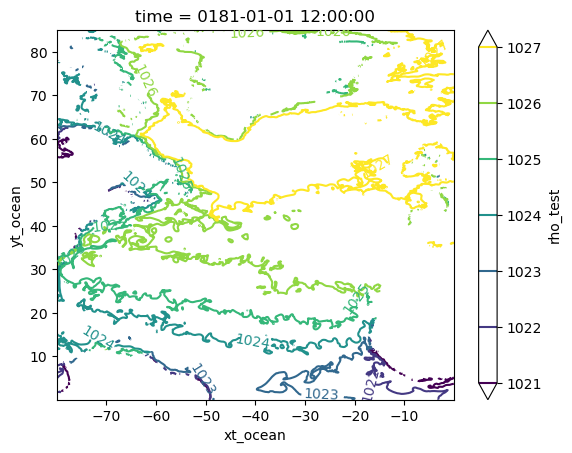

In [14]:
selection = dict(xt_ocean=slice(-80, 0), yt_ocean=slice(0,85))

C = rho.rho_test.sel(**selection)[0].plot.contour(levels=np.arange(1021,1028), add_colorbar=True)
plt.clabel(C);

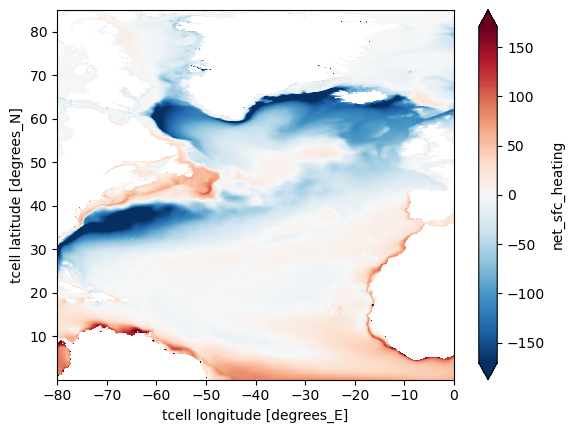

In [17]:
ds.net_sfc_heating.mean('time').sel(**selection).plot(robust=True)

In [20]:
coord  = cat["GFDL_CM2_6_grid"].to_dask()
rho_const = 1027.1 #kg/m^3 got this value from argmax of the mean pdf 
heat_capacity = 3.994e3 #J/kg˚C

/srv/conda/envs/notebook/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [23]:
heat_flux = (ds.net_sfc_heating * coord.area_t) / (rho_const * heat_capacity) #˚C m^3 / s

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 46.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 46.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


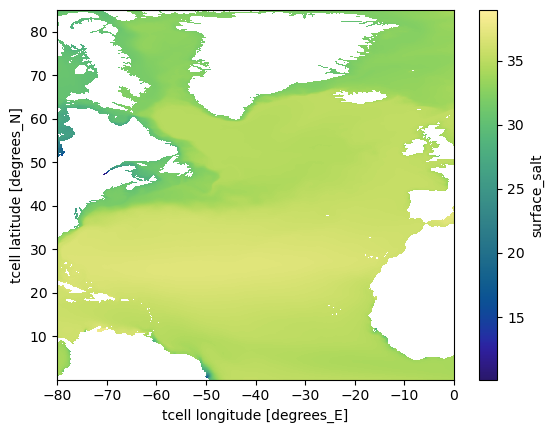

In [29]:
surf_ds.surface_salt.mean('time').sel(**selection).plot(cmap=cmocean.cm.haline)

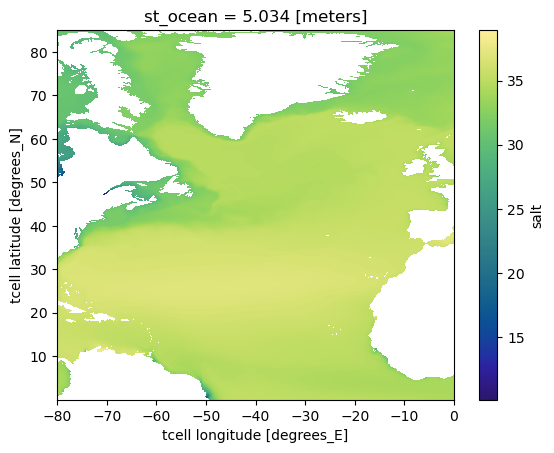

In [33]:
ds.salt.mean('time')[0].sel(**selection).plot(cmap=cmocean.cm.haline)

In [34]:
#surf salt flux
slt_flux = (ds.pme_river.where(coord.wet) * ds.salt.where(coord.wet) * 
            coord.area_t.where(coord.wet)) / rho_const #psu m^3 / s

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 46.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 46.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 46.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 46.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


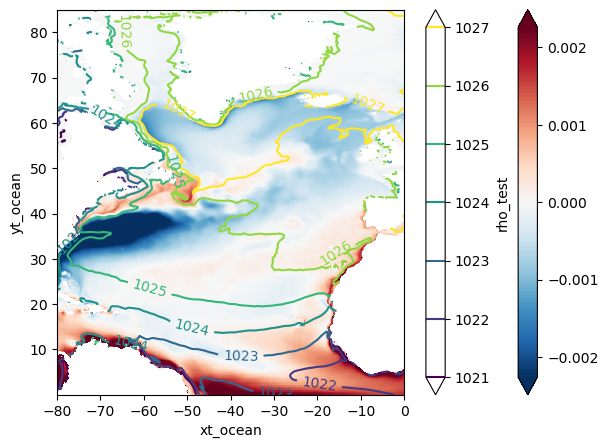

In [43]:
#plot contour of 26.5 isopycnal - rep NASTMW
fig, ax = plt.subplots(figsize=(7,5))
#selection = dict(xt_ocean=slice(-100, 30), yt_ocean=slice(-10, None))
selection = dict(xt_ocean=slice(-80, 0), yt_ocean=slice(0,85))
(heat_flux.mean('time')/1e6).sel(**selection).plot(cmap='RdBu_r', ax=ax, robust=True)
C = rho.rho_test.mean('time').sel(**selection).plot.contour(levels=np.arange(1021,1028), ax=ax, add_colorbar=True)
#C.collections[115].set_color('k')
#C.collections[115].set_linewidth(1.5);
plt.clabel(C);

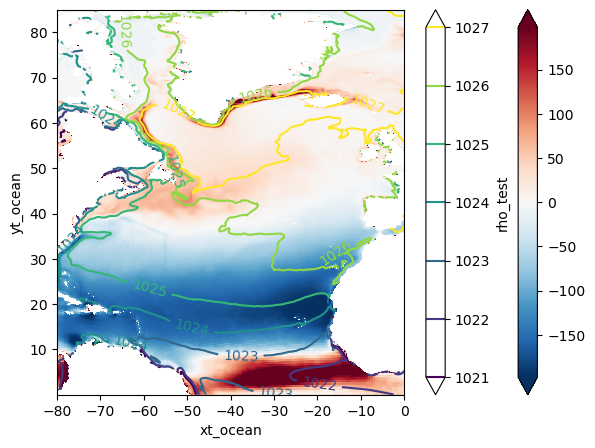

In [44]:
#plot contour of 26.5 isopycnal - rep NASTMW
fig, ax = plt.subplots(figsize=(7,5))
selection = dict(xt_ocean=slice(-80, 0), yt_ocean=slice(0,85))
slt_flux.mean('time').isel(st_ocean=0).sel(**selection).plot(cmap='RdBu_r', ax=ax, robust=True)
C = rho.rho_test.mean('time').sel(**selection).plot.contour(levels=np.arange(1021,1028), ax=ax, add_colorbar=True)
plt.clabel(C);

In [6]:
rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))
natl = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/basin-histograms/natl_hist.zarr'))
natl_surf = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/natl_hist_surf.zarr'))
mask = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/mask.zarr'))

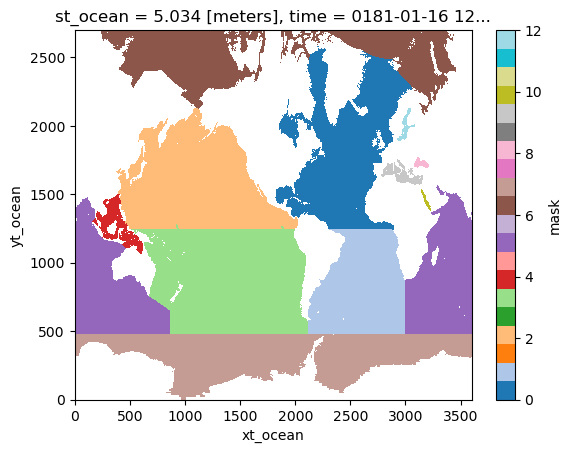

In [30]:
mask.mask.plot(cmap='tab20')

# Annual Mean Fig

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import gcsfs
import gcm_filters
import xgcm
from xhistogram.xarray import histogram

In [2]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))
natl = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/basin-histograms/natl_hist.zarr'))
natl_surf = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/natl_hist_surf.zarr'))
mask = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/mask.zarr'))

In [4]:
natl

<xarray.Dataset> Size: 47MB
Dimensions:    (time: 7305, rho0_bin: 199)
Coordinates:
  * rho0_bin   (rho0_bin) float64 2kB 1.015e+03 1.015e+03 ... 1.035e+03
  * time       (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
Data variables:
    cabbeling  (time, rho0_bin) float64 12MB dask.array<chunksize=(1, 199), meta=np.ndarray>
    rho_lap    (time, rho0_bin) float64 12MB dask.array<chunksize=(1, 199), meta=np.ndarray>
    sss        (time, rho0_bin) float64 12MB dask.array<chunksize=(1, 199), meta=np.ndarray>
    sst        (time, rho0_bin) float64 12MB dask.array<chunksize=(1, 199), meta=np.ndarray>

In [5]:
residual = ((natl.rho_lap - natl.sss - 
             natl.sst + natl.cabbeling)/1e6).isel(time=200)

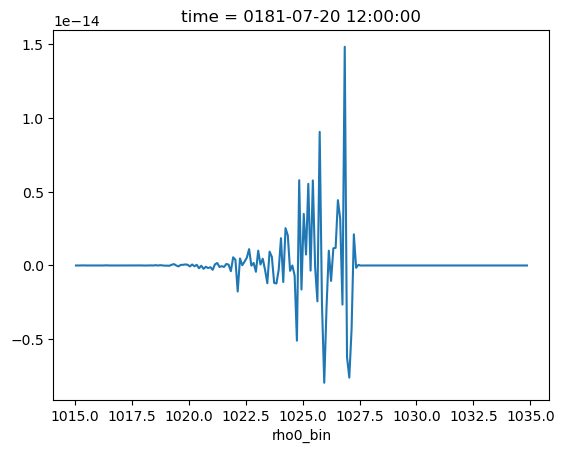

In [6]:
residual.plot()

In [7]:
natl_surf['OMEGA_surf_salt'] = - natl_surf.OMEGA_surf_salt

In [8]:
def ann_mean(mix, surf, basin_title):
    plt.rcParams['axes.grid']=True
    plt.rcParams['figure.autolayout']= False
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_colors=['blue', 'k', 
                 'orange', 'green']
    line_surf = ['purple', 'yellow']
    labels_mix = ['cabbeling', r'$\rho$', 'S', r'$\theta$']
    labels_surf = [r'$\theta_{S}$', r'S$_S$']
    
    for (i,j,k) in zip(list(mix.data_vars), line_colors, labels_mix):
        (mix[i].mean('time')/1e6).plot(label=k, color=j, ax=ax0)
    
    #plotting mixing residual
    #((mix.rho_lap + mix.cabbeling -
      #mix.sss - mix.sst).mean('time')/1e6).plot(label='residual', color='grey', 
                                                               # linestyle='dashed', ax=ax0)
    for (i,j,k) in zip(list(surf.data_vars), line_surf, labels_surf):
        (surf[i].mean('time')/1e6).plot(label=k, color=j, ax=ax1)
    ax0.legend()
    ax0.set_xlim(1016,1030)
    ax0.axvline(x=1026.7, ymin=-2.5, ymax=1.5, color='r', linestyle='--')
    #ax0.tick_params(axis="x", labelsize=20)
    ax0.set_ylim(-2.5, 1.5)
    ax0.set_ylabel(r'Transformation (Sv)', fontsize=16, labelpad=5)
    #ax0.grid()
    ax0.set_title('Mixing', fontsize=16)
    ax0.set_xlabel('')
    
    ax1.legend()
    ax1.set_xlim(1016,1030)
    ax1.axvline(x=1026.7, ymin=-2.5, ymax=1.5, color='r', linestyle='--')
    ax1.set_ylim(-15, 30)
    ax1.set_ylabel('')
    #ax1.grid()
    ax1.set_title('Air-Sea', fontsize=16)
    ax1.set_xlabel('')
    
    #fig.supxlabel('Rho bins', fontsize=16)
    plt.suptitle('CM2.6', fontsize=20)
    plt.savefig(f'{basin_title}_ann_mean_hist_fig.pdf');

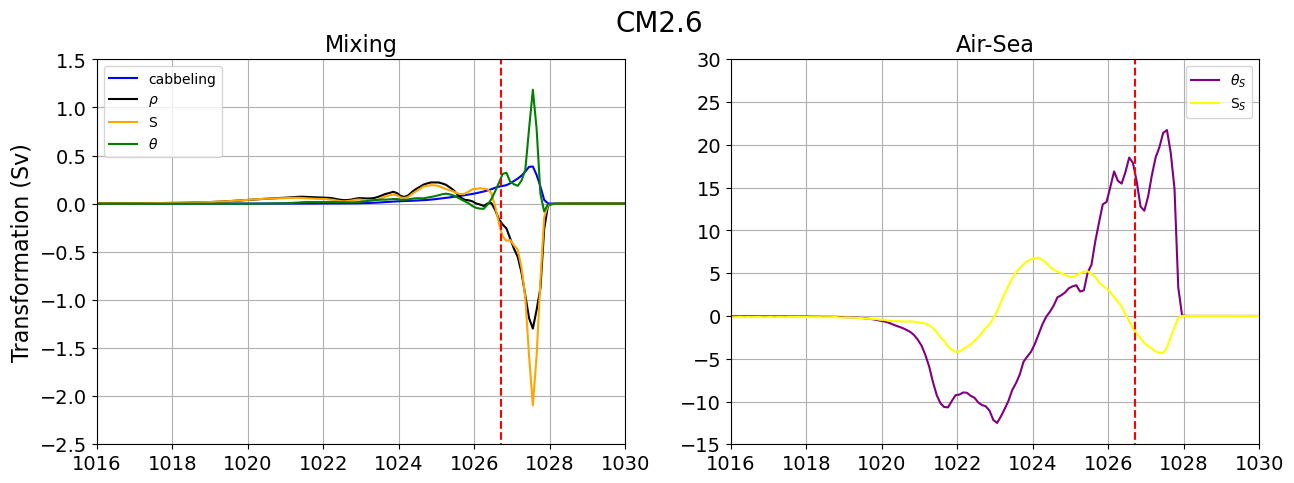

In [12]:
ann_mean(natl, natl_surf, 'NATL')

# 1) Spatial map of NASTMW outcropping in each month

In [7]:
rho0 = rho.rho_test
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)

In [8]:
atl_mask = mask.mask==0

In [9]:
rho0

<xarray.DataArray 'rho_test' (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<open_dataset-rho_test, shape=(7305, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

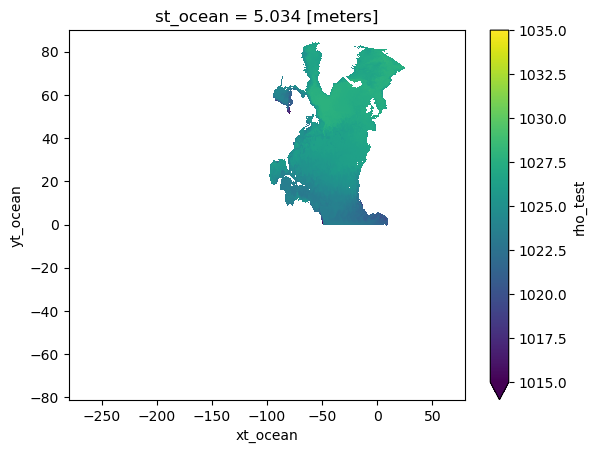

In [5]:
rho0[0].where(atl_mask).plot(vmin=1015, vmax=1035)

In [22]:
rho_bins[115]

1026.5000000000027

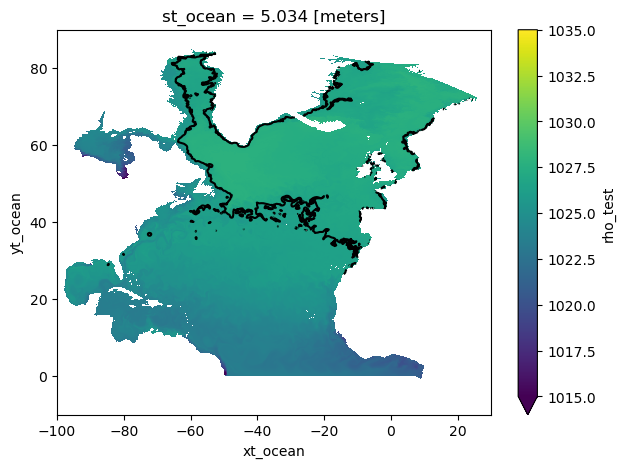

In [8]:
#plot contour of 26.5 isopycnal - rep NASTMW
fig, ax = plt.subplots(figsize=(7,5))
selection = dict(xt_ocean=slice(-100, 30), yt_ocean=slice(-10, None))
rho0[0].where(atl_mask).sel(**selection).plot(vmin=1015, vmax=1035, ax=ax)
C = rho0[0].where(atl_mask).sel(**selection).plot.contour(colors='k', levels=[rho_bins[115]], ax=ax)#, add_colorbar=True)
#C.collections[115].set_color('k')
#C.collections[115].set_linewidth(1.5);
#plt.clabel(C);

## A) Checking isopycnal value for NASTMW via cross sectional diagram


In [13]:
from fastjmd95 import jmd95numba

In [14]:
selection = dict(xt_ocean=slice(-100, 30), yt_ocean=slice(-10, None))
salt = ds.salt.where(atl_mask).sel(**selection)
temp = ds.temp.where(atl_mask).sel(**selection)
rho = jmd95numba.rho(salt, temp, 0)
delta_rho = 0.1
rho_bins = rho_bins = np.arange(1015, 1030, delta_rho)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(


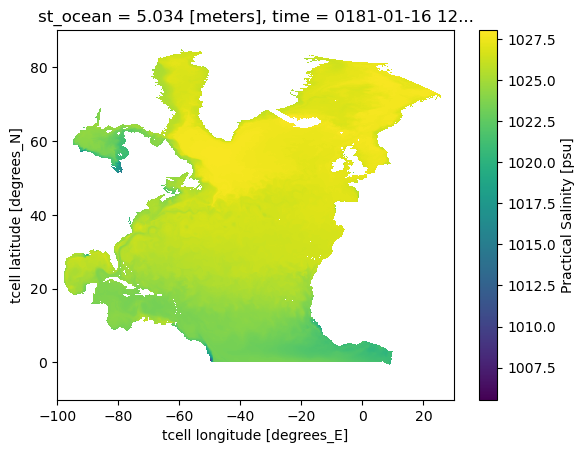

In [29]:
rho[0,0].plot()

In [20]:
t = rho.isel(time=0).sel(xt_ocean=-40, method='nearest').compute()

In [17]:
np.arange(1022, 1028, 0.2)

array([1022. , 1022.2, 1022.4, 1022.6, 1022.8, 1023. , 1023.2, 1023.4,
       1023.6, 1023.8, 1024. , 1024.2, 1024.4, 1024.6, 1024.8, 1025. ,
       1025.2, 1025.4, 1025.6, 1025.8, 1026. , 1026.2, 1026.4, 1026.6,
       1026.8, 1027. , 1027.2, 1027.4, 1027.6, 1027.8])

(500.0, 0.0)

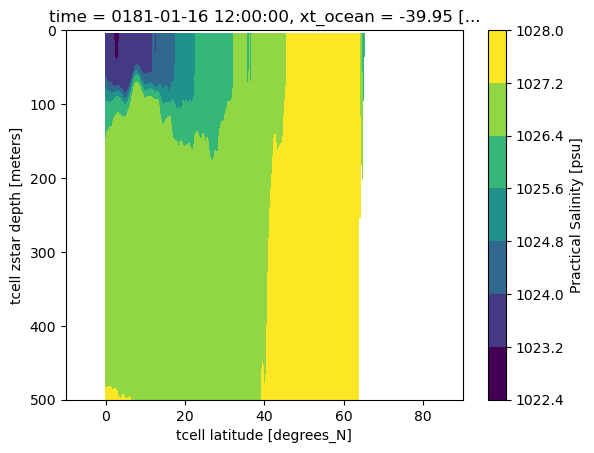

In [21]:
C = t.plot.contourf()
plt.ylim(500, 0)

(600.0, 0.0)

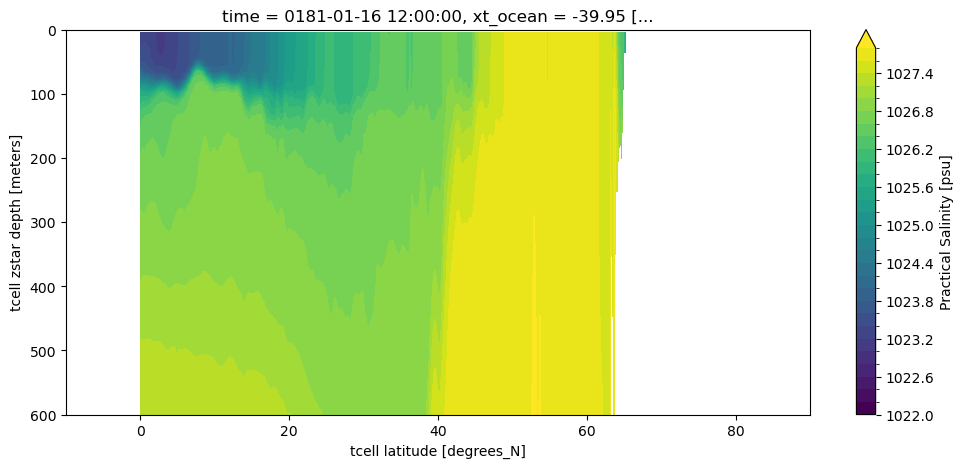

In [23]:
plt.figure(figsize=(12,5))
t.plot.contourf(levels=np.arange(1022, 1028, 0.2))
plt.ylim(600, 0)

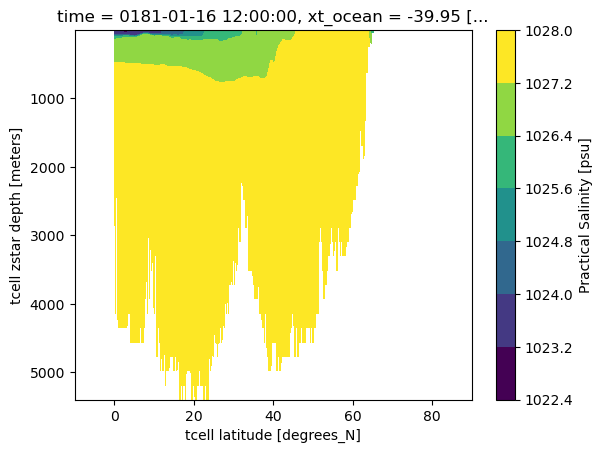

In [41]:
rho.isel(time=0).sel(xt_ocean=-40, method='nearest').plot.contourf(yincrease=False)

## Groupby $\rho$ and plot each month's contour map

In [10]:
selection = dict(xt_ocean=slice(-100, 30), yt_ocean=slice(-10, None))

rho_gb = rho0.where(atl_mask).sel(**selection).groupby('time.month').mean('time')
sst_gb = surf_ds.surface_temp.where(atl_mask).sel(**selection).groupby('time.month').mean('time')
sss_gb = surf_ds.surface_salt.where(atl_mask).sel(**selection).groupby('time.month').mean('time')

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(


In [11]:
rho_gb

<xarray.DataArray 'rho_test' (month: 12, yt_ocean: 1556, xt_ocean: 1300)>
dask.array<transpose, shape=(12, 1556, 1300), dtype=float64, chunksize=(1, 338, 450), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -99.95 -99.85 -99.75 ... 29.75 29.85 29.95
  * yt_ocean  (yt_ocean) float64 -9.999 -9.9 -9.802 -9.703 ... 89.89 89.94 89.98
    lat       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1556, 1300), meta=np.ndarray>
    lon       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(1556, 1300), meta=np.ndarray>
    st_ocean  float64 ...
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [12]:
rho_bins[117]

1026.7000000000025

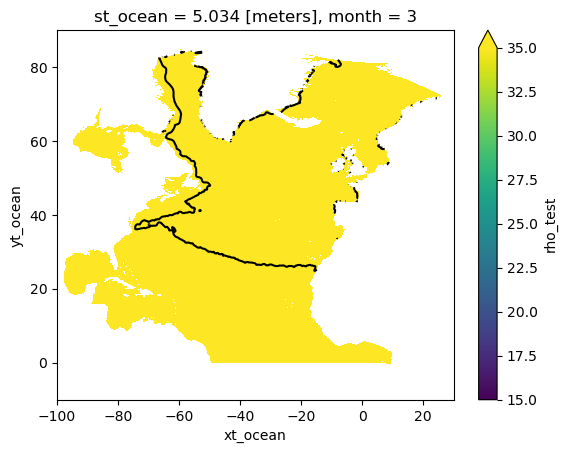

In [17]:
rho_gb[2].plot.contour(colors='k', levels=[rho_bins[113]])
rho_gb[2].plot(vmin=15, vmax=35)

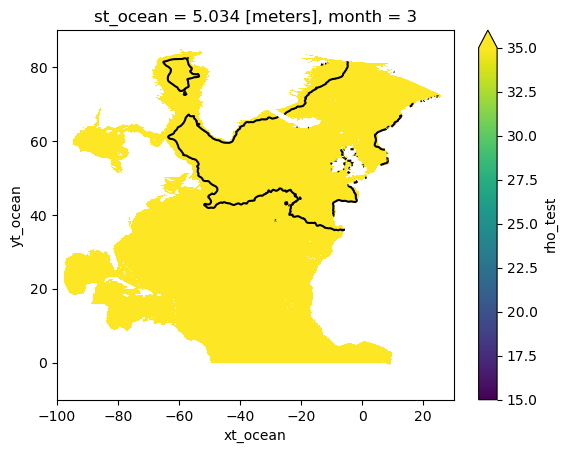

In [16]:
rho_gb[2].plot.contour(colors='k', levels=[rho_bins[118]])
rho_gb[2].plot(vmin=15, vmax=35)

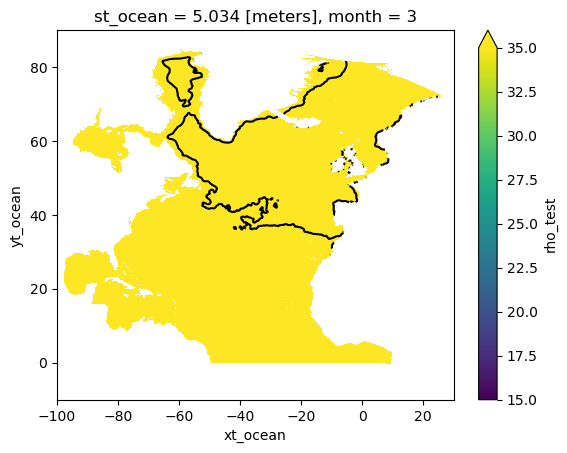

In [18]:
rho_gb[2].plot.contour(colors='k', levels=[rho_bins[117]])
rho_gb[2].plot(vmin=15, vmax=35)

In [11]:
import cmocean

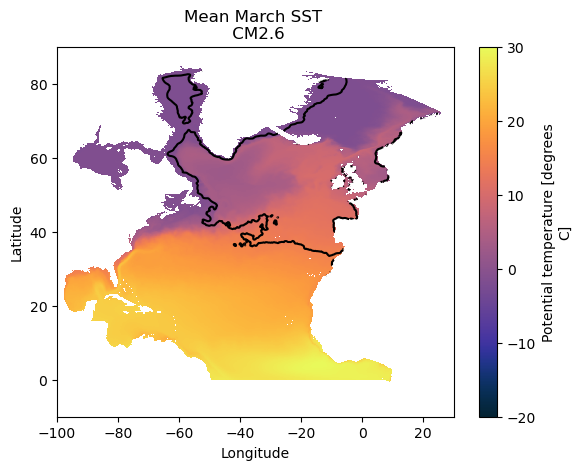

In [27]:
fig, ax = plt.subplots()
rho_gb.sel(month=3).plot.contour(colors='k', levels=[rho_bins[117]], ax=ax)
sst_gb.sel(month=3).plot(ax=ax, vmin=-20, vmax=30, cmap=cmocean.cm.thermal)
plt.title('Mean March SST \n CM2.6')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

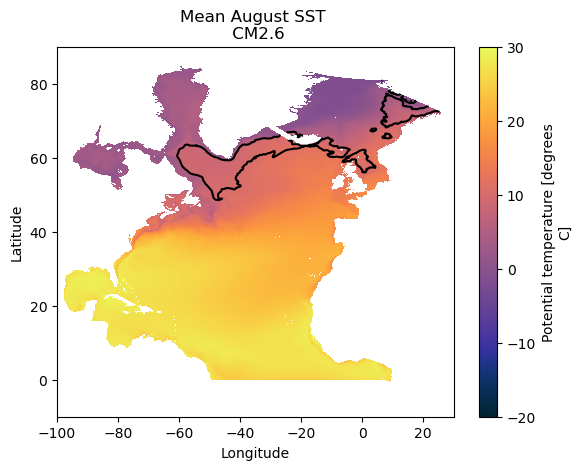

In [28]:
fig, ax = plt.subplots()
rho_gb.sel(month=8).plot.contour(colors='k', levels=[rho_bins[117]], ax=ax)
sst_gb.sel(month=8).plot(ax=ax, vmin=-20, vmax=30, cmap=cmocean.cm.thermal)
plt.title('Mean August SST \n CM2.6')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

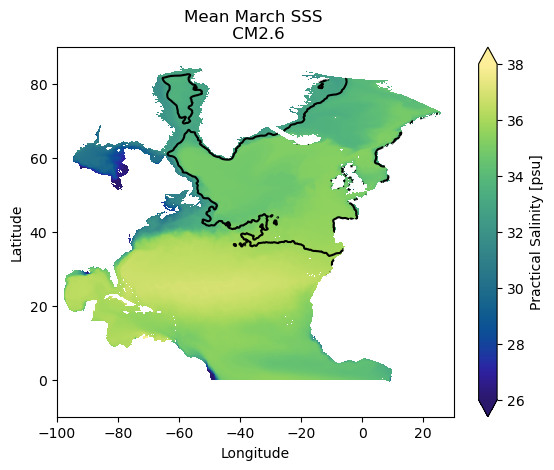

In [29]:
fig, ax = plt.subplots()
rho_gb.sel(month=3).plot.contour(colors='k', levels=[rho_bins[117]], ax=ax)
sss_gb.sel(month=3).plot(ax=ax, vmin=26, vmax=38, cmap=cmocean.cm.haline)
plt.title('Mean March SSS \n CM2.6')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

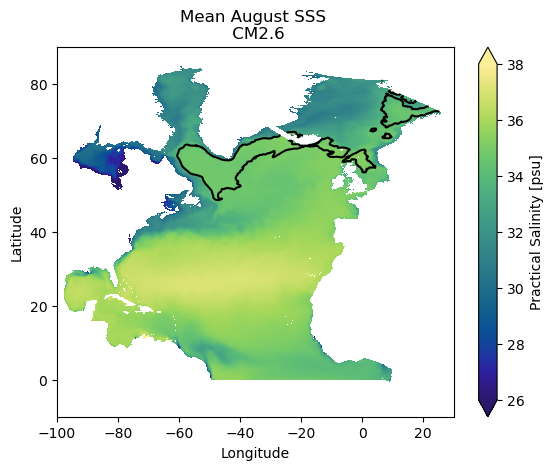

In [30]:
fig, ax = plt.subplots()
rho_gb.sel(month=8).plot.contour(colors='k', levels=[rho_bins[117]], ax=ax)
sss_gb.sel(month=8).plot(ax=ax, vmin=26, vmax=38, cmap=cmocean.cm.haline)
plt.title('Mean August SSS \n CM2.6')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

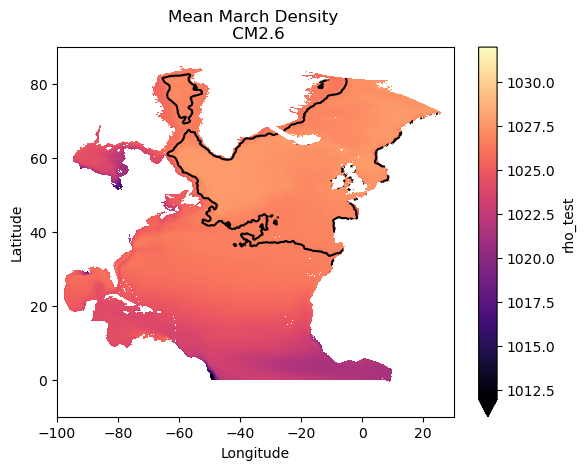

In [31]:
fig, ax = plt.subplots()
rho_gb.sel(month=3).plot.contour(colors='k', levels=[rho_bins[117]], ax=ax)
rho_gb.sel(month=3).plot(ax=ax, vmin=1012, vmax=1032, cmap='magma')
plt.title('Mean March Density \n CM2.6')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

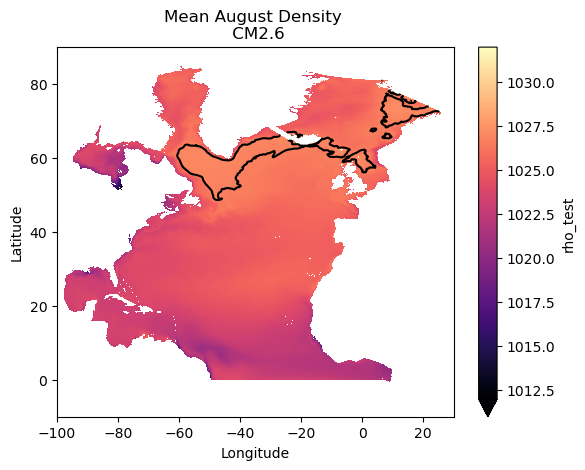

In [32]:
fig, ax = plt.subplots()
rho_gb.sel(month=8).plot.contour(colors='k', levels=[rho_bins[117]], ax=ax)
rho_gb.sel(month=8).plot(ax=ax, vmin=1012, vmax=1032, cmap='magma')
plt.title('Mean August Density \n CM2.6')
plt.ylabel('Latitude')
plt.xlabel('Longitude');

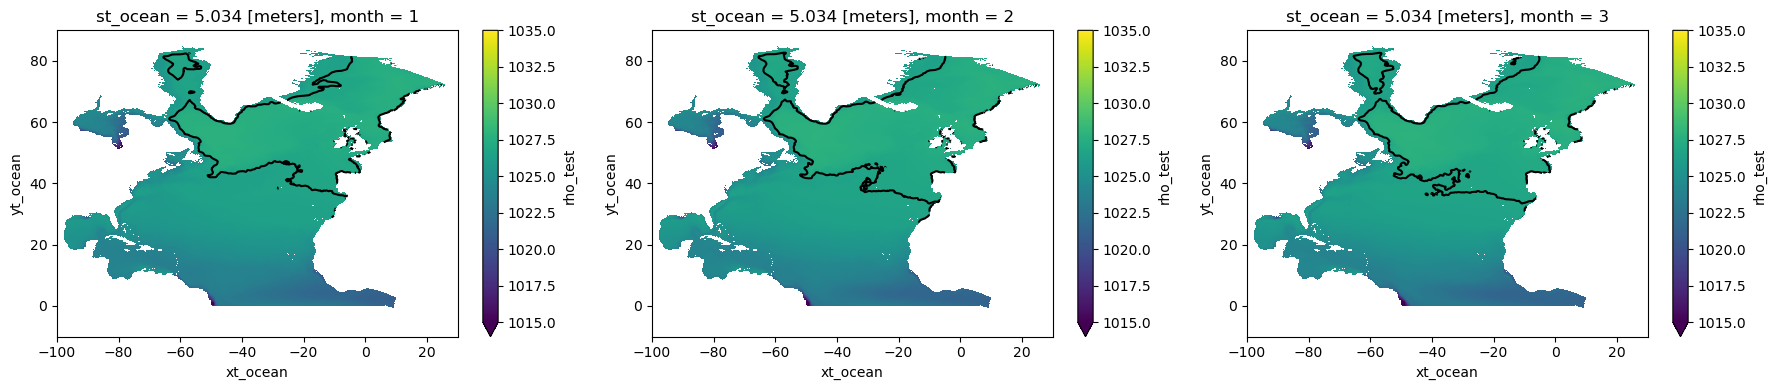

In [33]:
#first 3 months
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

rho_gb[0].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[0])
rho_gb[0].plot(vmin=1015, vmax=1035, ax=axes[0])

rho_gb[1].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[1])
rho_gb[1].plot(vmin=1015, vmax=1035, ax=axes[1])

rho_gb[2].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[2])
rho_gb[2].plot(vmin=1015, vmax=1035, ax=axes[2])

plt.tight_layout();

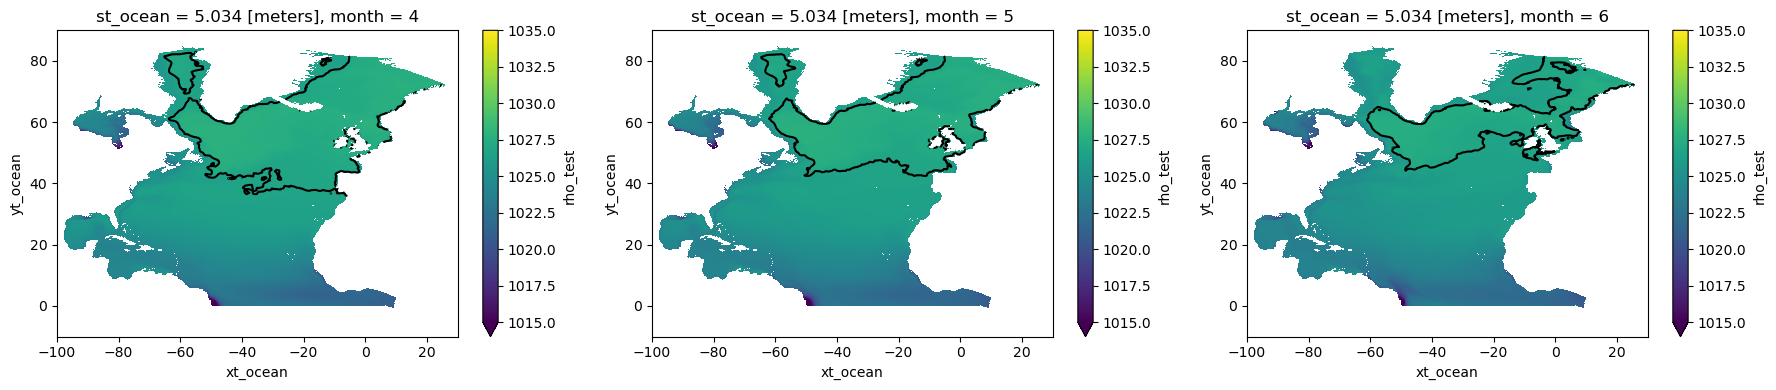

In [34]:
# April, May, June
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

rho_gb[3].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[0])
rho_gb[3].plot(vmin=1015, vmax=1035, ax=axes[0])

rho_gb[4].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[1])
rho_gb[4].plot(vmin=1015, vmax=1035, ax=axes[1])

rho_gb[5].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[2])
rho_gb[5].plot(vmin=1015, vmax=1035, ax=axes[2])

plt.tight_layout();

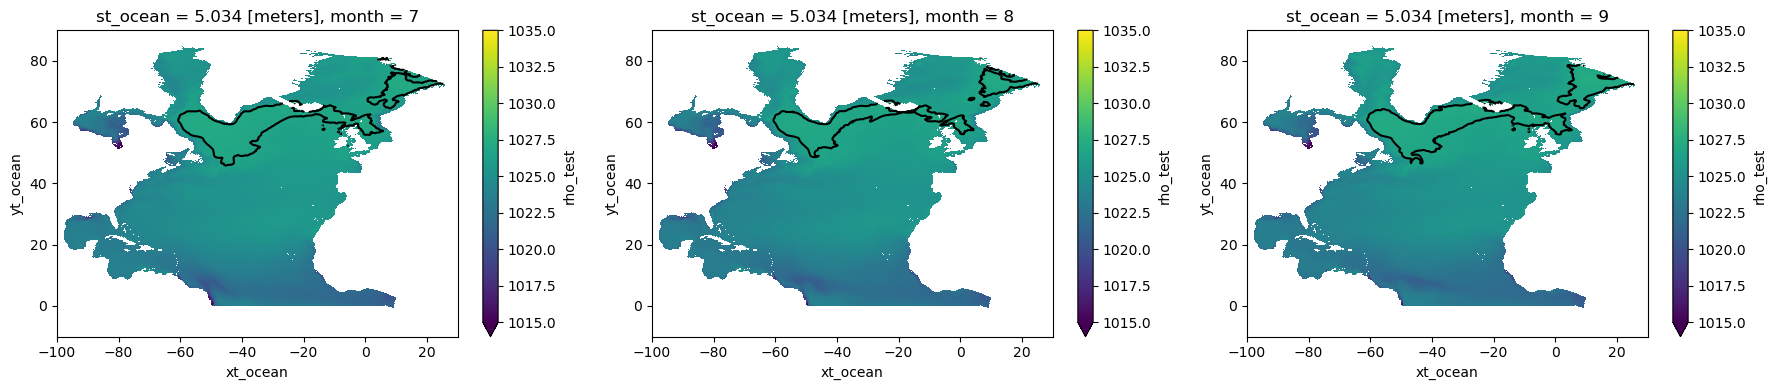

In [35]:
#July, Aug, Sept
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

rho_gb[6].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[0])
rho_gb[6].plot(vmin=1015, vmax=1035, ax=axes[0])

rho_gb[7].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[1])
rho_gb[7].plot(vmin=1015, vmax=1035, ax=axes[1])

rho_gb[8].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[2])
rho_gb[8].plot(vmin=1015, vmax=1035, ax=axes[2])

plt.tight_layout();

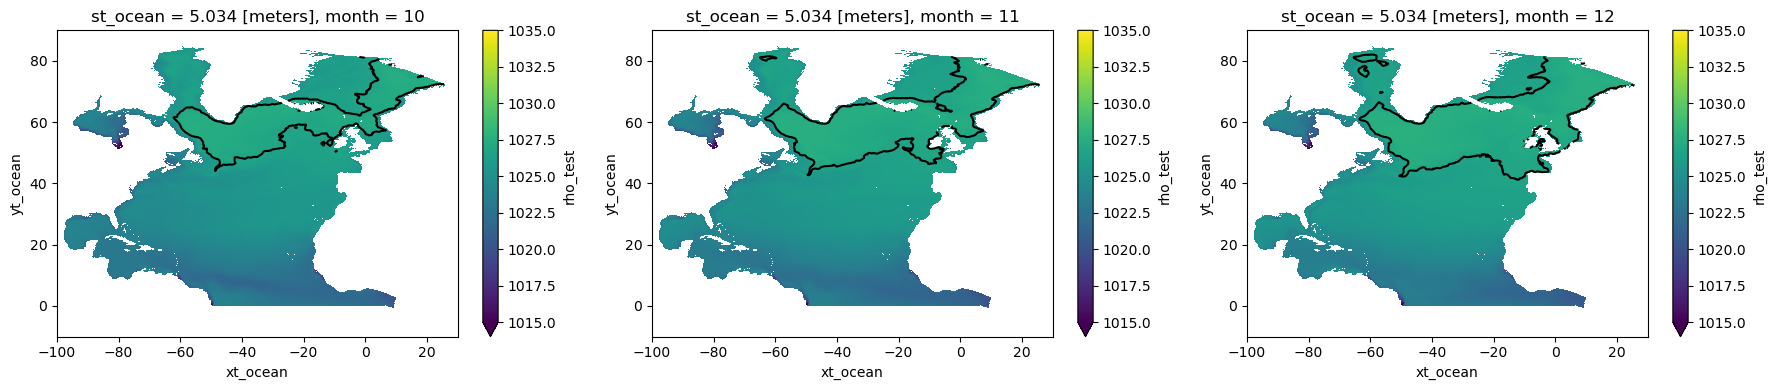

In [36]:
#Oct, Nov, Dec
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

rho_gb[9].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[0])
rho_gb[9].plot(vmin=1015, vmax=1035, ax=axes[0])

rho_gb[10].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[1])
rho_gb[10].plot(vmin=1015, vmax=1035, ax=axes[1])

rho_gb[11].plot.contour(colors='k', levels=[rho_bins[117]], ax=axes[2])
rho_gb[11].plot(vmin=1015, vmax=1035, ax=axes[2])

plt.tight_layout();

# Formation budget of NASTMW

In [13]:
nastmw = natl.sel(rho0_bin=1026.7, method='nearest')
nastmw_surf = natl_surf.sel(rho0_bin=1026.7, method='nearest')

In [14]:
nastmw_gb = nastmw.groupby('time.month').mean()
nastmw_gb_surf = nastmw_surf.groupby('time.month').mean()

In [15]:
nastmw_merged = xr.merge([nastmw_gb, nastmw_gb_surf])

In [16]:
nastmw_merged

<xarray.Dataset>
Dimensions:          (month: 12)
Coordinates:
    rho0_bin         float64 1.027e+03
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cabbeling        (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    rho_lap          (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sss              (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sst              (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_surf_heat  (month) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    OMEGA_surf_salt  (month) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [17]:
(nastmw_gb.rho_lap + nastmw_gb.cabbeling - nastmw_gb.sst - nastmw_gb.sss)[0].values

array(-2.03726813e-10)

In [18]:
def ann_mean(ds, basin_title):
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
    line_mix=['blue', 'k', 
                 'orange', 'green']
    line_surf = ['purple', 'yellow']
    labels_mix = ['cabbeling', r'$\rho$', 'S', r'$\theta$']
    labels_surf = [r'$\theta_{S}$', r'S$_S$']
    
    for (i,j,k) in zip(list(ds.data_vars)[:-2], line_mix, labels_mix): #slicing to mixing terms only
        (ds[i]/1e6).plot(label=f'{i}', color=j, ax=ax0)
    for (i,j,k) in zip(list(ds.data_vars)[-2:], line_surf, labels_surf): #slicing to surf terms only
        (ds[i]/1e6).plot(label=f'{i}', color=j, ax=ax1)
  
    ax0.legend()
    #ax0.set_xlim(1016,1030)
    ax0.set_ylabel(r'Transformation (Sv / $\Delta \sigma_0$)', fontsize=16)
    ax0.grid()
    ax0.set_title('Mixing terms')
    ax0.set_xlabel('')
    
    ax1.legend()
    #ax1.set_xlim(1016,1030)
    ax1.set_ylabel('')
    ax1.grid()
    ax1.set_title('Surface terms')
    ax1.set_xlabel('')
    
    fig.supxlabel('Month', fontsize=16)
    plt.suptitle('Monthly Mean Transformation', fontsize=20)
    plt.savefig(f'{basin_title}_mo_mean_hist_fig.pdf');

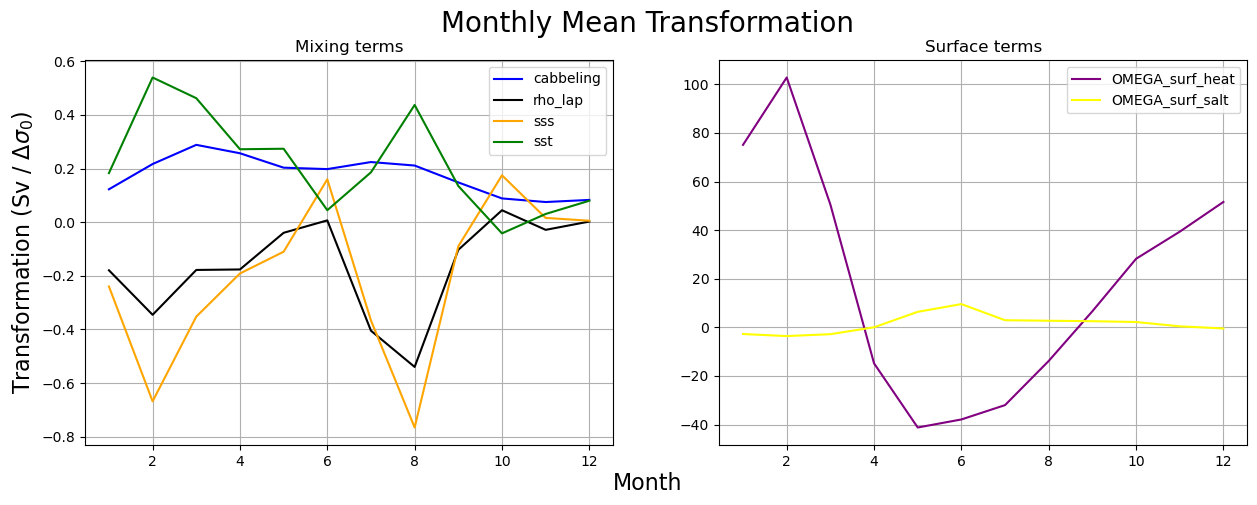

In [25]:
ann_mean(nastmw_merged, 'NATL')

## Ratio between mixing/air-sea for Temp and Salt

In [40]:
sss_ratio = nastmw_merged.sss / nastmw_merged.OMEGA_surf_salt
sst_ratio = nastmw_merged.sst / nastmw_merged.OMEGA_surf_heat

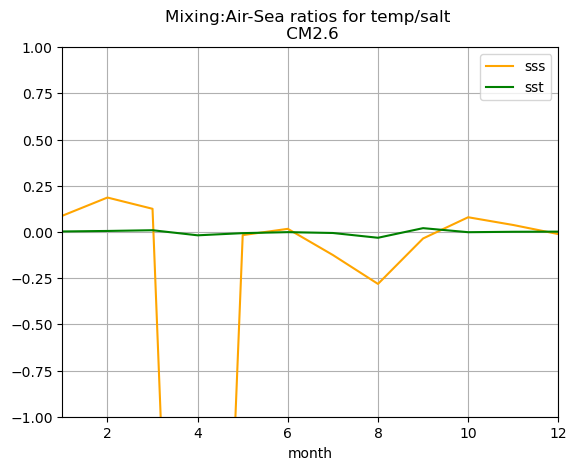

In [41]:
sss_ratio.plot(color='orange', label='sss')
sst_ratio.plot(color='green', label='sst')
plt.ylim(-1,1)
plt.xlim(1, 12)
plt.grid()
plt.legend()
plt.title('Mixing:Air-Sea ratios for temp/salt \n CM2.6');

# Pcolor fig

In [12]:
natl_mix_clim = natl.groupby('time.month').mean() / 1e6
natl_surf_clim = natl_surf.groupby('time.month').mean() / 1e6

In [13]:
natl_clim = xr.merge([natl_mix_clim, natl_surf_clim])

In [14]:
natl_clim

<xarray.Dataset> Size: 97kB
Dimensions:          (rho0_bin: 199, month: 12)
Coordinates:
  * rho0_bin         (rho0_bin) float64 2kB 1.015e+03 1.015e+03 ... 1.035e+03
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cabbeling        (month, rho0_bin) float64 19kB dask.array<chunksize=(1, 199), meta=np.ndarray>
    rho_lap          (month, rho0_bin) float64 19kB dask.array<chunksize=(1, 199), meta=np.ndarray>
    sss              (month, rho0_bin) float64 19kB dask.array<chunksize=(1, 199), meta=np.ndarray>
    sst              (month, rho0_bin) float64 19kB dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_surf_heat  (month, rho0_bin) float32 10kB dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_surf_salt  (month, rho0_bin) float32 10kB dask.array<chunksize=(1, 199), meta=np.ndarray>

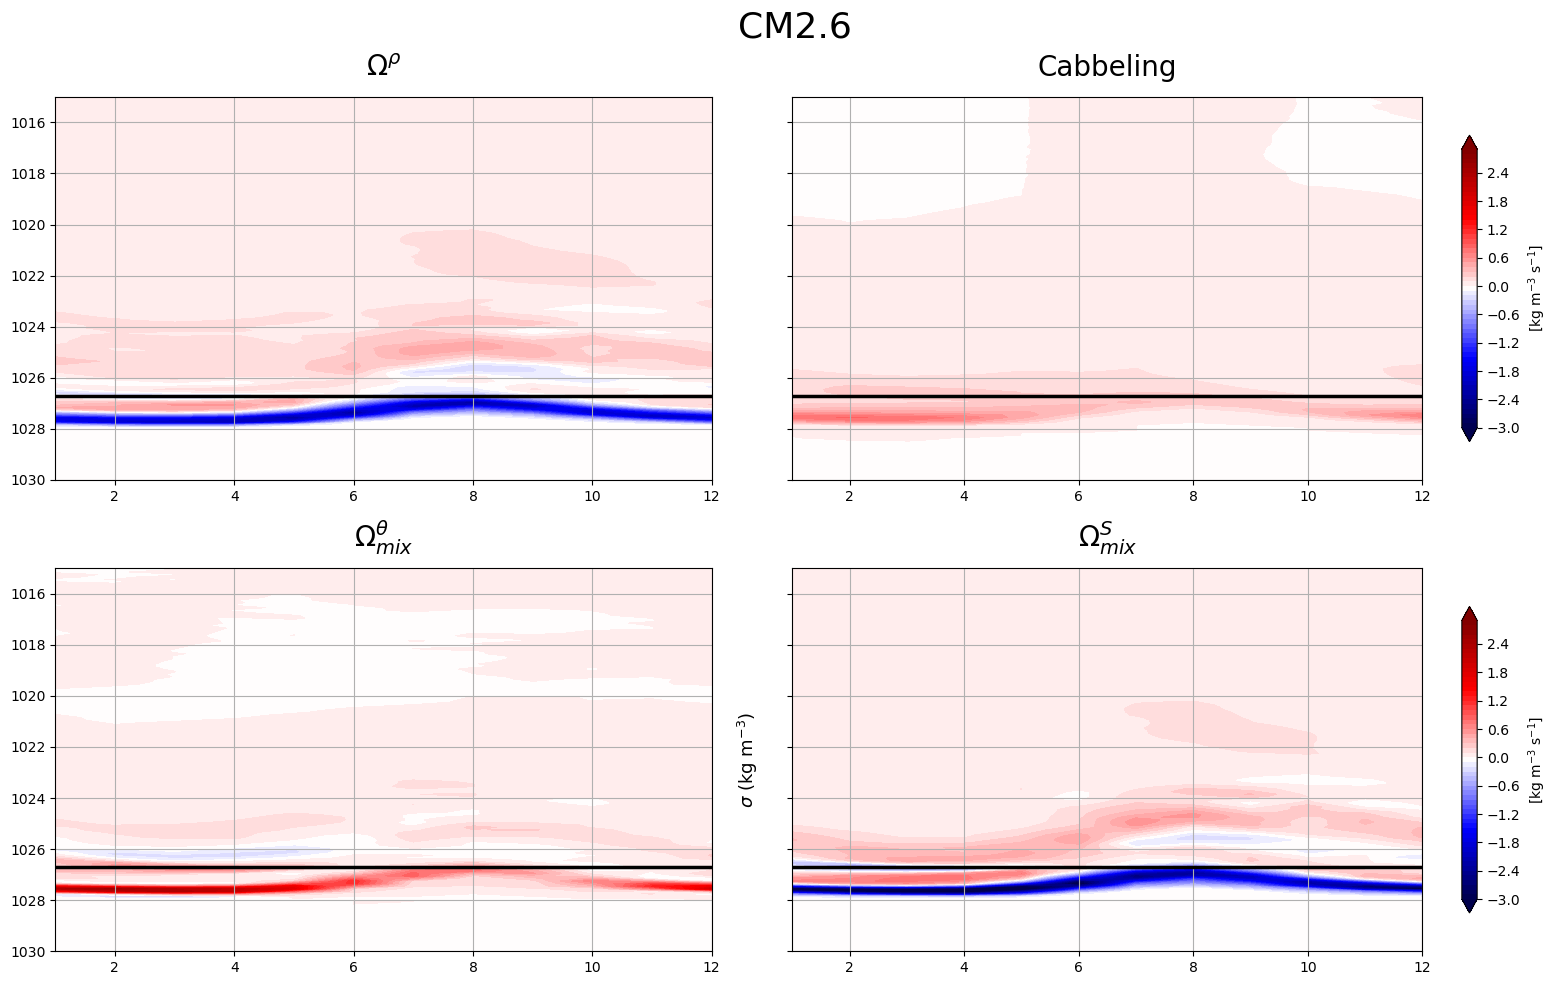

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharey=True, gridspec_kw={'width_ratios': [2.5,3]})

levels = np.arange(-3, 3, 0.1)

rho_clim = natl_clim.rho_lap
c = ax[0,0].contourf(rho_clim.month, 
                     rho_clim.rho0_bin,
                     rho_clim.T, cmap='seismic', levels=levels, extend='both')
#ax[0,0].set_ylabel(r'$\sigma$ (kg m$^{-3}$)', fontsize=13, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega^{\rho}$', fontsize=22, pad=15)
ax[0,0].grid()
ax[0,0].set_ylim(1030, 1015)
ax[0,0].axhline(y=1026.7, color='k', linewidth=2.5)

cab_clim = natl_clim.cabbeling
c_cab = ax[0,1].contourf(cab_clim.month, cab_clim.rho0_bin, cab_clim.T,
                         cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_cab, shrink=0.8, label=r'[kg m$^{-3}$ s$^{-1}$]')
ax[0,1].set_title(r'Cabbeling', fontsize=20, pad=15)
ax[0,1].grid()
ax[0,1].axhline(y=1026.7, color='k', linewidth=2.5)

sst_clim = natl_clim.sst
c_sst = ax[1,0].contourf(sst_clim.month, sst_clim.rho0_bin, sst_clim.T,
                           cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_sst, shrink=0.8, label='SST', ax=ax[1,0])
ax[1,0].set_title(r'$\Omega^{\theta}_{mix}$', fontsize=22, pad=15)
ax[1,0].grid()
ax[1,0].axhline(y=1026.7, color='k', linewidth=2.5)

sss_clim = natl_clim.sss
c_sss = ax[1,1].contourf(sss_clim.month, 
                                sss_clim.rho0_bin, 
                                sss_clim.T, cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_sss, shrink=0.8, label=r'[kg m$^{-3}$ s$^{-1}$]')
ax[1,1].set_ylabel(r'Density (kg m$^{-3}$)', fontsize=16, labelpad=20)
#ax[1,1].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^S_{mix}$', fontsize=22, pad=15)
ax[1,1].grid()
ax[1,1].axhline(y=1026.7, color='k', linewidth=2.5)

plt.suptitle('CM2.6', fontsize=26)
plt.tight_layout()
plt.savefig('clim-pcolor-cm2_6-mix-7.pdf', transparent=True);

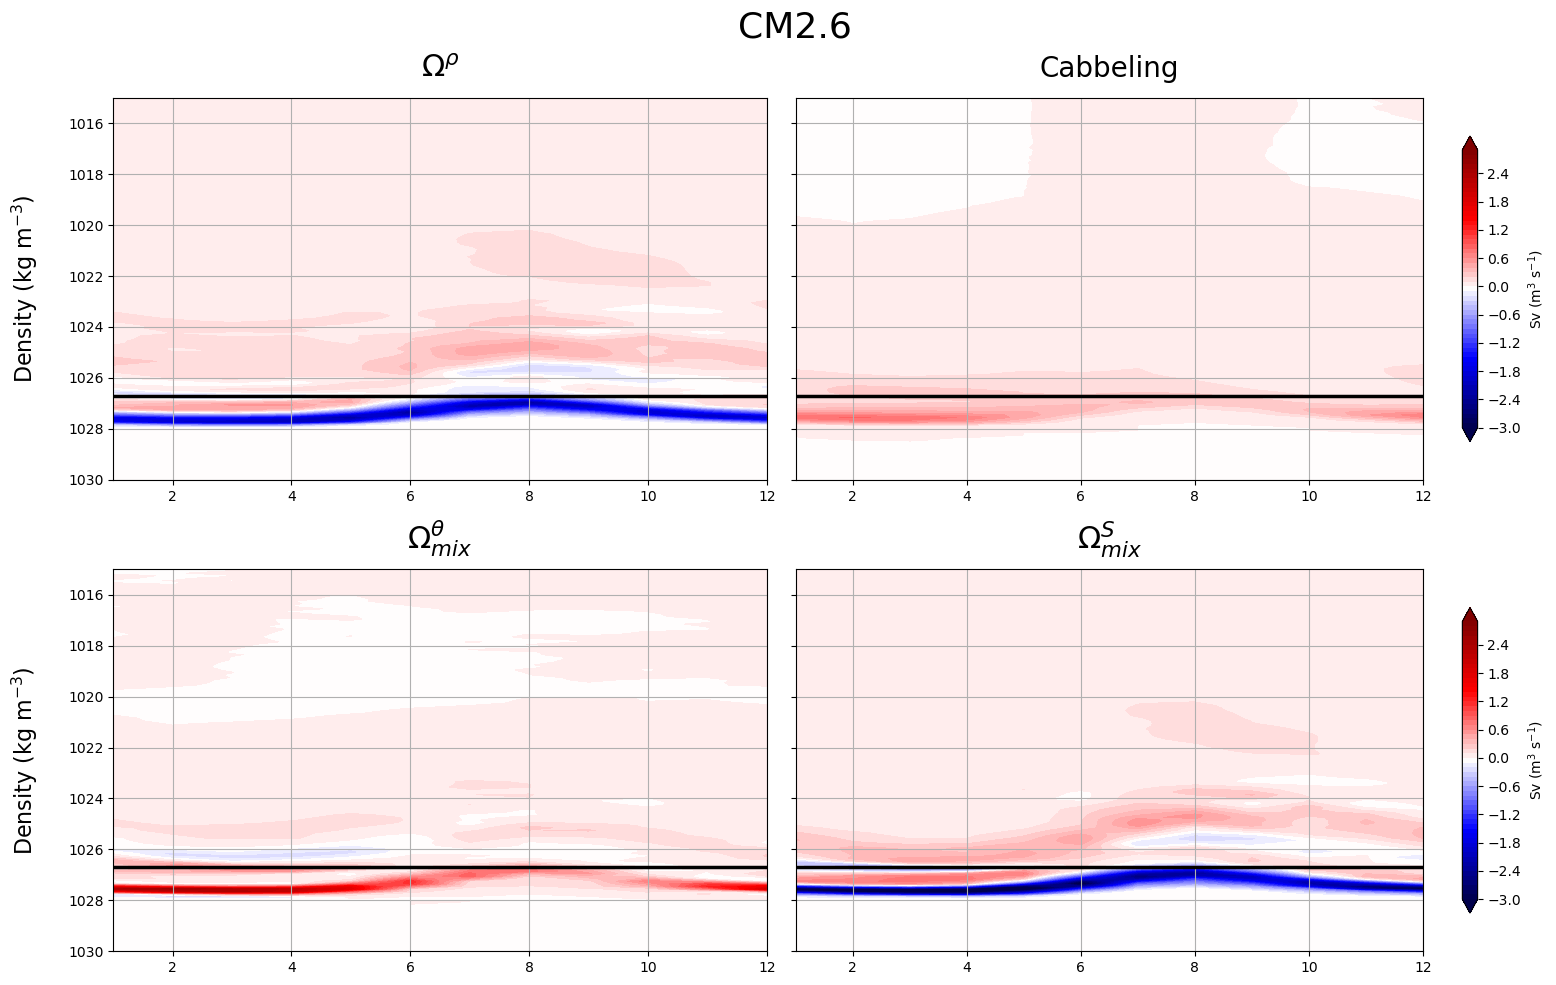

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharey=True, gridspec_kw={'width_ratios': [2.5,3]})

levels = np.arange(-3, 3, 0.1)

rho_clim = natl_clim.rho_lap
c = ax[0,0].contourf(rho_clim.month, 
                     rho_clim.rho0_bin,
                     rho_clim.T, cmap='seismic', levels=levels, extend='both')
ax[0,0].set_ylabel(r'Density (kg m$^{-3}$)', fontsize=16, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\Omega^{\rho}$', fontsize=22, pad=15)
ax[0,0].grid()
ax[0,0].set_ylim(1030, 1015)
ax[0,0].axhline(y=1026.7, color='k', linewidth=2.5)

cab_clim = natl_clim.cabbeling
c_cab = ax[0,1].contourf(cab_clim.month, cab_clim.rho0_bin, cab_clim.T,
                         cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_cab, shrink=0.8, label=r'Sv (m$^{3}$ s$^{-1}$)')
ax[0,1].set_title(r'Cabbeling', fontsize=20, pad=15)
ax[0,1].grid()
ax[0,1].axhline(y=1026.7, color='k', linewidth=2.5)

sst_clim = natl_clim.sst
c_sst = ax[1,0].contourf(sst_clim.month, sst_clim.rho0_bin, sst_clim.T,
                           cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_sst, shrink=0.8, label='SST', ax=ax[1,0])
ax[1,0].set_ylabel(r'Density (kg m$^{-3}$)', fontsize=16, labelpad=20)
ax[1,0].set_title(r'$\Omega^{\theta}_{mix}$', fontsize=22, pad=15)
ax[1,0].grid()
ax[1,0].axhline(y=1026.7, color='k', linewidth=2.5)

sss_clim = natl_clim.sss
c_sss = ax[1,1].contourf(sss_clim.month, 
                                sss_clim.rho0_bin, 
                                sss_clim.T, cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_sss, shrink=0.8, label=r'Sv (m$^{3}$ s$^{-1}$)')
#ax[1,1].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^S_{mix}$', fontsize=22, pad=15)
ax[1,1].grid()
ax[1,1].axhline(y=1026.7, color='k', linewidth=2.5)

plt.suptitle('CM2.6', fontsize=26)
plt.tight_layout()
plt.savefig('clim-pcolor-cm2_6-mix-7.pdf', transparent=True);

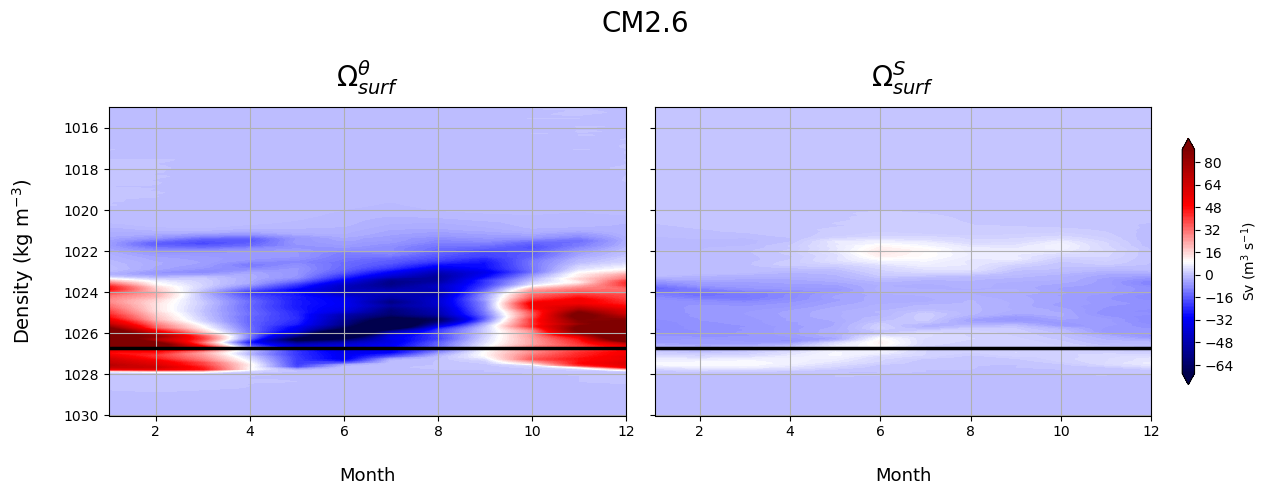

In [17]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(13, 5), sharey=True, gridspec_kw={'width_ratios': [2.5,3]})
levels = np.arange(-80, 80) + 10

surf_th_clim = natl_clim.OMEGA_surf_heat
c_surf_th = ax0.contourf(surf_th_clim.month, surf_th_clim.rho0_bin, 
                        surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
ax0.set_xlabel('Month', fontsize=13, labelpad=20)
ax0.set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
ax0.set_ylabel(r'Density (kg m$^{-3}$)', fontsize=14, labelpad=20)
ax0.grid()
ax0.axhline(y=1026.7, color='k', linewidth=2.5)
ax0.set_ylim(1030, 1015)

surf_slt_clim = natl_clim.OMEGA_surf_salt
c_surf_slt = ax1.contourf(surf_slt_clim.month, surf_slt_clim.rho0_bin, 
                        surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sv (m$^{3}$ s$^{-1}$)', ax=ax1)
ax1.set_xlabel('Month', fontsize=13, labelpad=20)
ax1.set_title(r'$\Omega^{S}_{surf}$', fontsize=20, pad=15)
ax1.grid()
ax1.axhline(y=1026.7, color='k', linewidth=2.5)

plt.suptitle('CM2.6', fontsize=20)
plt.tight_layout()
plt.savefig('clim-pcolor-cm2_6-surf-7.pdf', transparent=True);

In [27]:
client.close()
cluster.close()